In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import warnings
from typing import Tuple, Optional, List, Dict
from dataclasses import dataclass
import pandas as pd

In [3]:
@dataclass
class KinkingConfig:
    """Configuration class for kinking detection parameters."""

    # Smoothing parameters
    smooth_sigma: float = 1.0  # Gaussian smoothing sigma
    enable_smoothing: bool = False

    # Angular analysis parameters 
    window_size: int = 3 # Window size for angle calculation
    angle_threshold: float = 90.0 # Threshold for significant kinking (degrees)

    # Resampling parameters
    resample_factor: Optional[float] = None  # If None, use original sampling

    # Visualization parameters
    colormap: str = 'viridis'
    line_width: float = 3.0
    point_size: float = 50
    highlight_kinks: bool = True
    show_annotations: bool = True

    # Detection parameters
    min_kink_separation: float = 5.0  # Minimum distance between detected kinks
    percentile_threshold: float = 95.0  # Percentile for automatic threshold detection


class VesselKinkingAnalyzer:
    """
    A comprehensive analyzer for detecting and visualizing kinking in 3D vessel centerlines.
    
    This class provides methods for:
    - Computing directional changes and curvature
    - Detecting regions of high angular change
    - Visualizing curves with bending severity color coding
    - Identifying and annotating kink locations
    """

    def __init__(self, config: KinkingConfig = None):
        """
        Initialize the analyzer with configuration parameters.
        
        Args:
            config: KinkingConfig object with analysis parameters
        """
        self.config = config or KinkingConfig()
        self.centerline = None
        self.angles = None
        self.curvature = None
        self.kink_indices = None
        self.smoothed_centerline = None

    def load_centerline(self, centerline: np.ndarray) -> None:
        """
        Load and validate the 3D centerline data.
        
        Args:
            centerline: NumPy array of shape (N, 3) representing the centerline
        """

        if not isinstance(centerline, np.ndarray):
            raise ValueError("Centerline must be a NumPy array.")

        if centerline.shape[1] != 3:
            raise ValueError("Centerline must have shape (N, 3) for 3D coordinates.")

        if centerline.shape[0] < 3:
            raise ValueError("Centerline must have at least 3 points.")

        self.centerline = centerline.copy()

        # Resample if needed
        if self.config.resample_factor is not None:
            self.centerline = self._resample_centerline(self.centerline)

        # Apply smoothing if enabled
        if self.config.enable_smoothing:
            self.smoothed_centerline = self._smooth_centerline(self.centerline)
        else:
            self.smoothed_centerline = self.centerline.copy()

    def _resample_centerline(self, centerline: np.ndarray) -> np.ndarray:
        """
        Resample the centerline to a uniform spacing.
        
        Args:
            centerline: Original centerline points
            
        Returns:
            Resampled centerline points
        """
        # Calculate cumulative distances
        distances = np.cumsum(np.r_[0, np.linalg.norm(np.diff(centerline, axis=0), axis=1)])

        # Create interpolation functions for each dimension
        interp_funcs = [interp1d(distances, centerline[:, i], kind='cubic')
                        for i in range(3)]

        # Generate new uniform sampling 
        new_distances = np.linspace(0, distances[-1], int(len(centerline) * self.config.resample_factor))

        # Interpolate to get new centerline points
        new_centerline = np.column_stack([func(new_distances) for func in interp_funcs])

        return new_centerline


    def _smooth_centerline(self, centerline: np.ndarray) -> np.ndarray:
        """
        Apply Gaussian smoothing to the centerline.
        
        Args:
            centerline: Original centerline points
            
        Returns:
            Smoothed centerline points
        """
        smoothed = np.zeros_like(centerline)
        for i in range(3):
            smoothed[:, i] = gaussian_filter1d(centerline[:, i], sigma=self.config.smooth_sigma)

        return smoothed

    def compute_directional_changes(self) -> np.ndarray:
        """
        Compute directional changes (angles) along the centerline.
        
        Returns:
            Array of angles in degrees
        """

        if self.smoothed_centerline is None:
            raise ValueError("Centerline must be loaded before computing angles.")

        points = self.smoothed_centerline
        n_points = points.shape[0] # Or you can use len(points) if you prefer
        angles = np.zeros(n_points)

        half_window = self.config.window_size // 2

        for i in range(half_window, n_points - half_window):
            # Get vectors before and after current point
            vec_before = points[i] - points[i - half_window]
            vec_after = points[i + half_window] - points[i]

            # Normalize vectors
            norm_before = np.linalg.norm(vec_before)
            norm_after = np.linalg.norm(vec_after)

            if norm_before > 1e-10 and norm_after > 1e-10:
                vec_before_norm = vec_before / norm_before
                vec_after_norm = vec_after / norm_after

                # Calculate angle between vectors
                dot_product = np.clip(np.dot(vec_before_norm, vec_after_norm), -1, 1)
                angle = np.arccos(dot_product)
                angles[i] = np.degrees(angle)

        # Handle boundary conditions
        angles[:half_window] = angles[half_window]
        angles[-half_window:] = angles[-half_window-1]

        self.angles = angles
        return angles

    def compute_curvature(self) -> np.ndarray:
        """
        Compute curvature along the centerline using the discrete method.
        
        Returns:
            Array of curvature values
        """

        if self.smoothed_centerline is None:
            raise ValueError("Centerline must be loaded before computing curvature.")

        points = self.smoothed_centerline
        n_points = points.shape[0]
        curvature = np.zeros(n_points)

        for i in range(1, n_points - 1):
            # Get three consecutive points 
            p1, p2, p3 = points[i-1], points[i], points[i+1]

            # Calculate vectors
            v_before = p2 - p1
            v_after = p3 - p2

            # Calculate curvature using cross product magnitude
            cross_product = np.cross(v_before, v_after)
            cross_magnitude = np.linalg.norm(cross_product)

            # Calculate segment lengths
            len_before = np.linalg.norm(v_before)
            len_after = np.linalg.norm(v_after)

            if len_before > 1e-10 and len_after > 1e-10:
                # Curvature formula: 2 * |cross product| / (length before * length after * (len_before + len_after))
                curvature[i] = 2 * cross_magnitude / (len_before * len_after * (len_before + len_after))
        
        # Handle boundary conditions
        curvature[0] = curvature[1]
        curvature[-1] = curvature[-2]

        self.curvature = curvature
        return curvature

    def detect_kinks(self, use_adaptive_threshold: bool = True, 
                    use_combined_strategy: bool = False,
                    curvature_weight: float = 0.3) -> List[int]:
        """
        Detect kink locations using angular changes and optionally combined with curvature.

        This method provides two detection strategies:
        1. Angular-only: Uses only angular changes (default, backward compatible)
        2. Combined: Uses weighted combination of angular changes and curvature

        The algorithm:
        1. Computes detection metric(s) and thresholds
        2. Uses scipy.signal.find_peaks to identify local maxima
        3. Prioritizes sharper bends by sorting peaks by severity
        4. Applies distance-based suppression to avoid multiple kinks in same bend
        5. Returns final kinks sorted by position along the curve

        Args:
            use_adaptive_threshold: If True, use percentile-based threshold
            use_combined_strategy: If True, combine angular changes with curvature
            curvature_weight: Weight for curvature in combined strategy (0.0-1.0)
        
        Returns:
            List of indices where kinks are detected, sorted by position
        """

        if self.angles is None:
            self.compute_directional_changes()
        
        # Compute detection metric based on strategy
        if use_combined_strategy:
            detection_metric, threshold = self._compute_combined_kink_metric(use_adaptive_threshold, curvature_weight)
            metric_name = "combined"
        else:
            # Use angular changes only (default behavior)
            detection_metric = self.angles
            if use_adaptive_threshold:
                threshold = np.percentile(self.angles, self.config.percentile_threshold)
            else:
                threshold = self.config.angle_threshold
            metric_name = "angular"

        # Find local maxima (peaks) in detection metric
        peak_indices, _ = find_peaks(detection_metric, 
                                    height=threshold, # Minimum peak height (our threshold)
                                    distance=1) # Minimum distance between peaks (in array indices)

        # Handle case where no peaks are found
        if len(peak_indices) == 0:
            self.kink_indices = []
            return []

        # Get peak heights (metric values) for sorting
        peak_values = detection_metric[peak_indices]

        # Sort peaks by descending metric value (prioritize more severe kinks)
        sorted_indices = np.argsort(peak_values)[::-1]
        sorted_peaks = peak_indices[sorted_indices]
        sorted_peak_values = peak_values[sorted_indices]

        # Apply distance-based suppression to avoid multiple kinks in same bend
        selected_kinks = []
        supressed_indices = set()

        for i, peak_idx in enumerate(sorted_peaks):
            # Skip if peak is already suppressed
            if peak_idx in supressed_indices:
                continue

            # Add this peak as a detected kink
            selected_kinks.append(peak_idx)

            # Calculate Euclidean distances from this kink to all remaining peaks
            current_point = self.smoothed_centerline[peak_idx]

            for j in range(i + 1, len(sorted_peaks)):
                other_peak_idx = sorted_peaks[j]

                # Skip if already suppressed 
                if other_peak_idx in supressed_indices:
                    continue
                
                # Calculate Euclidean distance between the two kink candidates
                other_point = self.smoothed_centerline[other_peak_idx]
                distance = np.linalg.norm(current_point - other_point)

                # Suppress if within minimum separation distance
                if distance < self.config.min_kink_separation:
                    supressed_indices.add(other_peak_idx)

        # Sort final kinks by position along curve (increasing index order)
        selected_kinks.sort()

        # Store results
        self.kink_indices = selected_kinks

        return selected_kinks

    def _compute_combined_kink_metric(self, use_adaptive_threshold: bool, 
                                    curvature_weight: float) -> Tuple[np.ndarray, float]:
        """
        Compute a combined kink detection metric using angular changes and curvature.
        
        This method:
        1. Normalizes both angular changes and curvature to [0, 1] range
        2. Combines them using weighted average
        3. Computes appropriate threshold for the combined metric
        
        Args:
            use_adaptive_threshold: If True, use percentile-based threshold
            curvature_weight: Weight for curvature component (0.0-1.0)
            
        Returns:
            Tuple of (combined_metric, threshold)
        """
        if self.curvature is None:
            self.compute_curvature()
        
        # Validate weight parameter
        curvature_weight = np.clip(curvature_weight, 0.0, 1.0)
        angle_weight = 1.0 - curvature_weight
        
        # Normalize angular changes to [0, 1] range
        angle_max = np.max(self.angles)
        angle_min = np.min(self.angles)
        if angle_max > angle_min:
            normalized_angles = (self.angles - angle_min) / (angle_max - angle_min)
        else:
            normalized_angles = np.zeros_like(self.angles)
        
        # Normalize curvature to [0, 1] range
        curvature_max = np.max(self.curvature)
        curvature_min = np.min(self.curvature)
        if curvature_max > curvature_min:
            normalized_curvature = (self.curvature - curvature_min) / (curvature_max - curvature_min)
        else:
            normalized_curvature = np.zeros_like(self.curvature)
        
        # Compute combined metric as weighted average
        combined_metric = (angle_weight * normalized_angles + 
                          curvature_weight * normalized_curvature)
        
        # Compute threshold for combined metric
        if use_adaptive_threshold:
            # Use percentile of combined metric
            threshold = np.percentile(combined_metric, self.config.percentile_threshold)
        else:
            # Convert angular threshold to normalized scale and adjust for combination
            normalized_angle_threshold = (self.config.angle_threshold - angle_min) / (angle_max - angle_min)
            # For combined metric, we use a weighted threshold approach
            # Assuming curvature threshold would be at similar relative level
            threshold = angle_weight * normalized_angle_threshold + curvature_weight * 0.5
            threshold = np.clip(threshold, 0.0, 1.0)
        
        return combined_metric, threshold

    def visualize_kinking(self, figsize: Tuple[int, int] = (12, 8), 
                         save_path: Optional[str] = None) -> plt.Figure:
        """
        Create a 3D visualization of the centerline with kinking information.
        Args:
            figsize: Figure size tuple
            save_path: Optional path to save the figure
            
        Returns:
            Matplotlib figure object
        """
        if self.smoothed_centerline is None:
            raise ValueError("Load centerline data first")
        
        if self.angles is None:
            self.compute_directional_changes()
        
        if self.kink_indices is None:
            self.detect_kinks()
        
        # Create figure and 3D axis
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot the centerline colored by angular change
        points = self.smoothed_centerline
        
        # Create segments for coloring
        for i in range(len(points) - 1):
            color_value = self.angles[i]
            ax.plot([points[i, 0], points[i+1, 0]], 
                   [points[i, 1], points[i+1, 1]], 
                   [points[i, 2], points[i+1, 2]], 
                   c=plt.get_cmap(self.config.colormap)(color_value / np.max(self.angles)),
                   linewidth=self.config.line_width)
        
        # Highlight kinks if enabled
        if self.config.highlight_kinks and self.kink_indices:
            kink_points = points[self.kink_indices]
            ax.scatter(kink_points[:, 0], kink_points[:, 1], kink_points[:, 2],
                      c='red', s=self.config.point_size * 2, marker='o', 
                      alpha=0.8, label='Detected Kinks')
        
        # Add annotations if enabled
        if self.config.show_annotations and self.kink_indices:
            for i, idx in enumerate(self.kink_indices):
                point = points[idx]
                ax.text(point[0], point[1], point[2], f'K{i+1}', 
                       fontsize=10, color='red', weight='bold')
        
        # Customize the plot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Vessel Centerline with Kinking Analysis')
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=self.config.colormap, 
                                  norm=plt.Normalize(vmin=0, vmax=np.max(self.angles)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
        cbar.set_label('Angular Change (degrees)')
        
        if self.config.highlight_kinks and self.kink_indices:
            ax.legend()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig    

    def generate_report(self) -> Dict:
        """
        Generate a comprehensive analysis report.
        
        Returns:
            Dictionary containing analysis results
        """
        if self.angles is None:
            self.compute_directional_changes()
        
        if self.curvature is None:
            self.compute_curvature()
        
        if self.kink_indices is None:
            self.detect_kinks()
        
        report = {
            'centerline_length': len(self.centerline),
            'total_path_length': np.sum(np.linalg.norm(
                np.diff(self.smoothed_centerline, axis=0), axis=1)),
            'mean_angular_change': np.mean(self.angles),
            'max_angular_change': np.max(self.angles),
            'std_angular_change': np.std(self.angles),
            'mean_curvature': np.mean(self.curvature),
            'max_curvature': np.max(self.curvature),
            'num_kinks_detected': len(self.kink_indices),
            'kink_locations': self.kink_indices.copy() if self.kink_indices else [],
            'kink_angles': [self.angles[i] for i in self.kink_indices] if self.kink_indices else [],
            'config_used': self.config
        }
        
        return report
    
    def plot_angular_profile(self, figsize: Tuple[int, int] = (12, 6)) -> plt.Figure:
        """
        Plot the angular change profile along the centerline.
        
        Args:
            figsize: Figure size tuple
            
        Returns:
            Matplotlib figure object
        """
        if self.angles is None:
            self.compute_directional_changes()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # Plot angular changes
        ax1.plot(self.angles, linewidth=2, label='Angular Change')
        ax1.axhline(y=self.config.angle_threshold, color='red', linestyle='--', 
                   label=f'Threshold ({self.config.angle_threshold}°)')
        
        if self.kink_indices:
            ax1.scatter(self.kink_indices, [self.angles[i] for i in self.kink_indices],
                       c='red', s=100, marker='o', alpha=0.7, label='Detected Kinks')
        
        ax1.set_xlabel('Point Index')
        ax1.set_ylabel('Angular Change (degrees)')
        ax1.set_title('Angular Change Profile')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot curvature
        if self.curvature is None:
            self.compute_curvature()
        
        ax2.plot(self.curvature, linewidth=2, color='green', label='Curvature')
        ax2.set_xlabel('Point Index')
        ax2.set_ylabel('Curvature')
        ax2.set_title('Curvature Profile')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


Computing directional changes...
Computing curvature...
Detecting kinks...

=== ANALYSIS REPORT ===
Centerline length: 52 points
Total path length: 66.81 units
Mean angular change: 32.54°
Max angular change: 148.05°
Number of kinks detected: 1
Kink locations and angles:
  Kink 1: Index 16, Angle 50.77°

Generating visualizations...


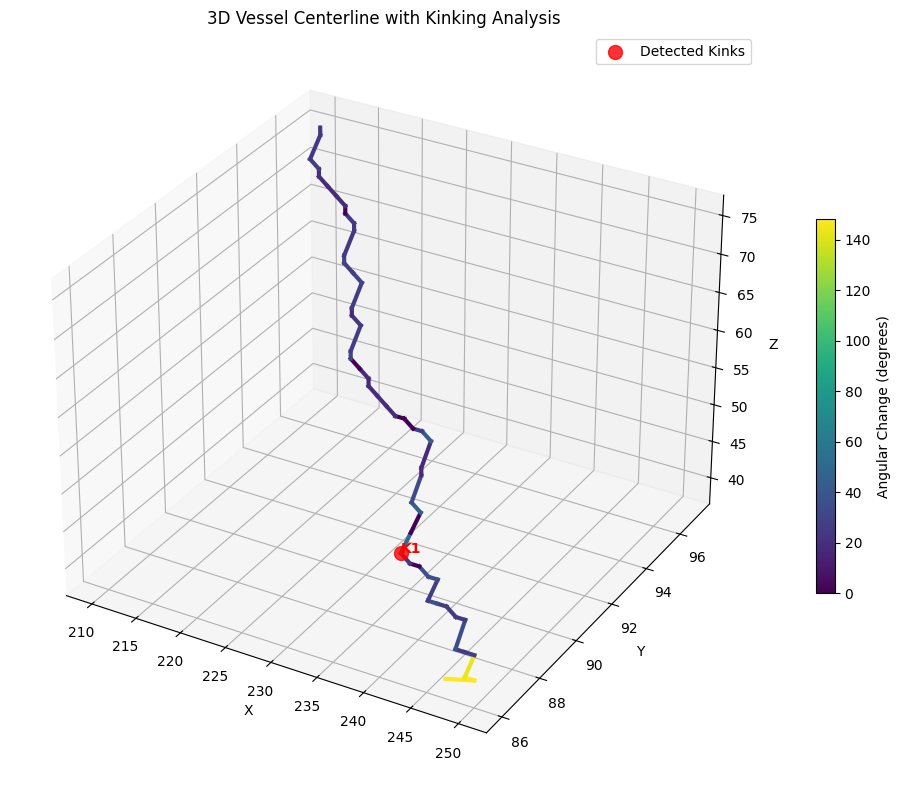

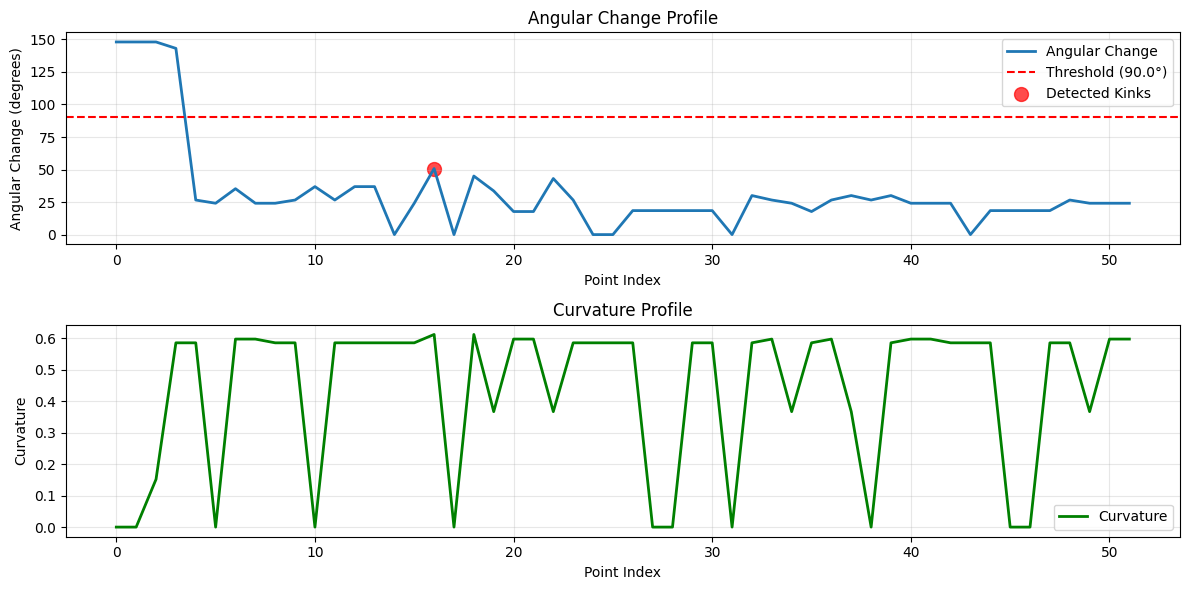

In [4]:
# Step 1: Load the CSV
df = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Illiac/Diameters/040_diameters_l_illiac.csv")

# Step 2: Extract X, Y, Z as a NumPy array
points = df[['X', 'Y', 'Z']].values  # Make sure these column names match your CSV exactly

# Step 3: Create analyzer with default or custom settings
config = KinkingConfig(
    smooth_sigma=1.0,
    enable_smoothing=False,
    angle_threshold=90.0,
    window_size=5,
    min_kink_separation=3.0,
    percentile_threshold=90.0,
    highlight_kinks=True,
    show_annotations=True
)

analyzer = VesselKinkingAnalyzer(config)
analyzer.load_centerline(points)

# Perform analysis
print("Computing directional changes...")
angles = analyzer.compute_directional_changes()

print("Computing curvature...")
curvature = analyzer.compute_curvature()

print("Detecting kinks...")
kinks = analyzer.detect_kinks(use_adaptive_threshold=True)

# Generate report
report = analyzer.generate_report()

# Print results
print("\n=== ANALYSIS REPORT ===")
print(f"Centerline length: {report['centerline_length']} points")
print(f"Total path length: {report['total_path_length']:.2f} units")
print(f"Mean angular change: {report['mean_angular_change']:.2f}°")
print(f"Max angular change: {report['max_angular_change']:.2f}°")
print(f"Number of kinks detected: {report['num_kinks_detected']}")

if report['kink_locations']:
    print("Kink locations and angles:")
    for i, (loc, angle) in enumerate(zip(report['kink_locations'], report['kink_angles'])):
        print(f"  Kink {i+1}: Index {loc}, Angle {angle:.2f}°")

# Create visualizations
print("\nGenerating visualizations...")

# 3D visualization
fig_3d = analyzer.visualize_kinking(figsize=(12, 8))

# Angular profile
fig_profile = analyzer.plot_angular_profile(figsize=(12, 6))

plt.show()

# Plot for two iliacs

In [5]:
df_right_iliac = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Illiac/Diameters/010_diameters_r_illiac.csv")
df_left_iliac = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Illiac/Diameters/010_diameters_l_illiac.csv")

points_left = df_left_iliac[['X', 'Y', 'Z']].values
points_right = df_right_iliac[['X', 'Y', 'Z']].values

In [6]:
analyzer_left = VesselKinkingAnalyzer(config)
analyzer_left.load_centerline(points_left)
analyzer_left.compute_directional_changes()
analyzer_left.compute_curvature()
analyzer_left.detect_kinks()

analyzer_right = VesselKinkingAnalyzer(config)
analyzer_right.load_centerline(points_right)
analyzer_right.compute_directional_changes()
analyzer_right.compute_curvature()
analyzer_right.detect_kinks()

[np.int64(6),
 np.int64(14),
 np.int64(51),
 np.int64(58),
 np.int64(69),
 np.int64(76)]

In [7]:
def plot_comparison(analyzer1: VesselKinkingAnalyzer, label1: str,
                    analyzer2: VesselKinkingAnalyzer, label2: str,
                    figsize=(14, 6)) -> plt.Figure:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Angular comparison
    ax1.plot(analyzer1.angles, label=f'{label1} - Angular Change', linewidth=2)
    ax1.plot(analyzer2.angles, label=f'{label2} - Angular Change', linewidth=2)
    ax1.axhline(y=config.angle_threshold, color='red', linestyle='--', label='Threshold')
    ax1.set_title('Angular Change Comparison')
    ax1.set_ylabel('Angle (degrees)')
    ax1.legend()
    ax1.grid(True)

    # Curvature comparison
    ax2.plot(analyzer1.curvature, label=f'{label1} - Curvature', linewidth=2)
    ax2.plot(analyzer2.curvature, label=f'{label2} - Curvature', linewidth=2)
    ax2.set_title('Curvature Comparison')
    ax2.set_xlabel('Point Index')
    ax2.set_ylabel('Curvature')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

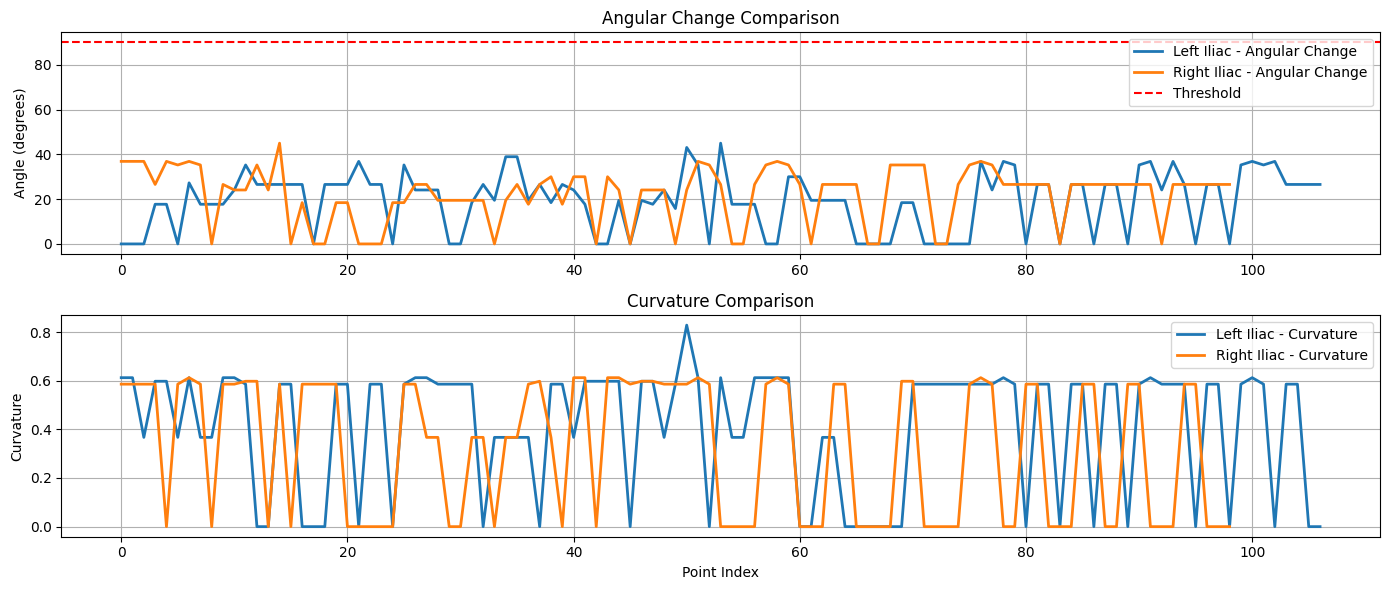

In [8]:
fig_comparison = plot_comparison(analyzer_left, "Left Iliac",
                                 analyzer_right, "Right Iliac")
plt.show()

In [9]:
# def plot_3d_comparison(analyzer1, label1, analyzer2, label2, figsize=(12, 10)):
#     fig = plt.figure(figsize=figsize)
#     ax = fig.add_subplot(111, projection='3d')

#     for analyzer, label, color in zip([analyzer1, analyzer2], [label1, label2], ['blue', 'green']):
#         points = analyzer.smoothed_centerline
#         ax.plot(points[:, 0], points[:, 1], points[:, 2], label=label, color=color)

#         if analyzer.kink_indices:
#             kink_pts = points[analyzer.kink_indices]
#             ax.scatter(kink_pts[:, 0], kink_pts[:, 1], kink_pts[:, 2], c='red', s=50, label=f'{label} Kinks')

#     ax.set_title('3D Comparison of Iliac Vessels')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     return fig

def plot_3d_comparison(analyzer1, label1, analyzer2, label2, figsize=(14, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    for analyzer, label, color in zip([analyzer1, analyzer2], [label1, label2], ['blue', 'green']):
        points = analyzer.smoothed_centerline
        ax.plot(points[:, 0], points[:, 1], points[:, 2], label=label, color=color)

        if analyzer.kink_indices:
            kink_pts = points[analyzer.kink_indices]
            ax.scatter(kink_pts[:, 0], kink_pts[:, 1], kink_pts[:, 2], c='red', s=50, label=f'{label} Kinks')

    ax.set_title('3D Comparison of Iliac Vessels')
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_zlabel('Z', fontsize=14)
    ax.view_init(elev=20, azim=-70)
    ax.legend()
    return fig


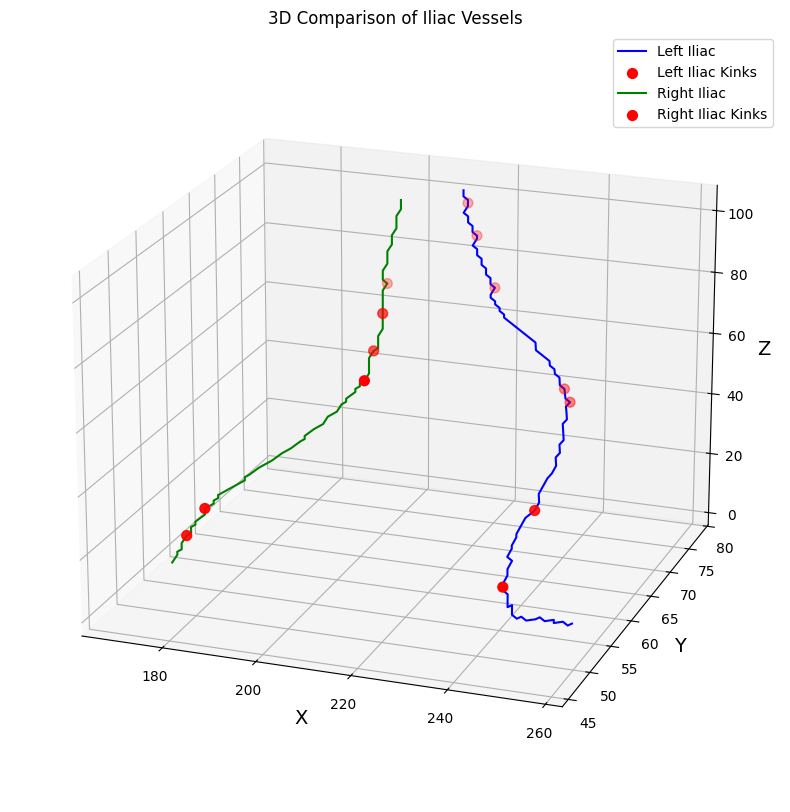

In [10]:
fig_3d_comparison = plot_3d_comparison(analyzer_left, "Left Iliac", analyzer_right, "Right Iliac")

plt.show()


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

def plot_3d_comparison(analyzer1, label1, analyzer2, label2, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    colors = ['blue', 'green']
    analyzers = [analyzer1, analyzer2]
    labels = [label1, label2]

    for analyzer, label, color in zip(analyzers, labels, colors):
        points = analyzer.smoothed_centerline
        ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color)

        if analyzer.kink_indices:
            kink_pts = points[analyzer.kink_indices]
            ax.scatter(kink_pts[:, 0], kink_pts[:, 1], kink_pts[:, 2], c='red', s=50)

    ax.set_title('3D Comparison of Iliac Vessels')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)

    # Adjust 3D view for better axis label visibility
    ax.view_init(elev=20, azim=-70)

    # Custom legend
    legend_elements = [
        Line2D([0], [0], color='blue', label=f'{label1}'),
        Line2D([0], [0], color='green', label=f'{label2}'),
        Line2D([0], [0], marker='o', color='w', label='Kinks',
               markerfacecolor='red', markersize=8)
    ]
    ax.legend(handles=legend_elements)

    return fig


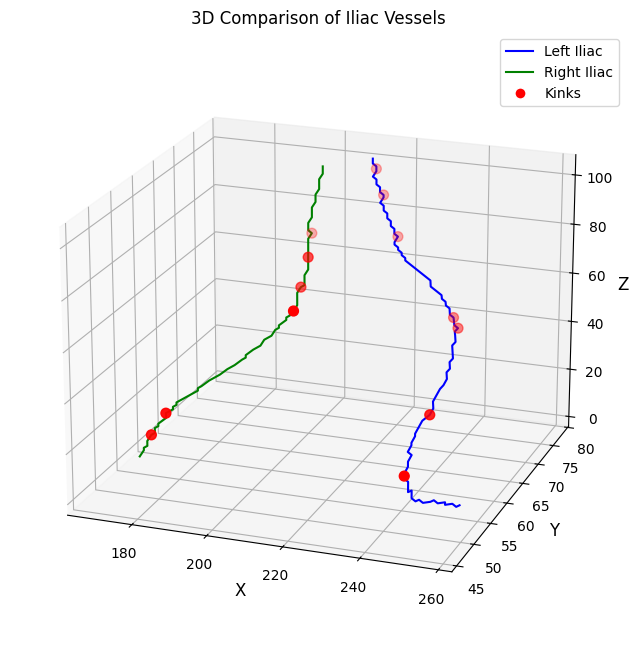

In [12]:
fig_3d_comparison = plot_3d_comparison(analyzer_left, "Left Iliac", analyzer_right, "Right Iliac")
plt.savefig("3d_comparison.png", dpi=300, transparent=True)
plt.show()

# Vertical Plot 

In [178]:
def plot_vertical_comparison_with_kinks(analyzer_left: VesselKinkingAnalyzer,
                                                           analyzer_right: VesselKinkingAnalyzer,
                                                           label_left: str = "Left Iliac",
                                                           label_right: str = "Right Iliac",
                                                           figsize=(12, 12)) -> plt.Figure:
    fig, axs = plt.subplots(4, 1, figsize=figsize)

    # Colors
    angle_color_left = 'royalblue'
    angle_color_right = 'darkorange'
    curv_color_left = 'green'
    curv_color_right = 'limegreen'
    kink_color = 'red'

    # Max lengths for alignment
    max_len_angle = max(len(analyzer_left.angles), len(analyzer_right.angles))
    max_len_curv = max(len(analyzer_left.curvature), len(analyzer_right.curvature))

    # ---------- Angular Change: Left ----------
    axs[0].plot(analyzer_left.angles, label=f'{label_left} - Angle', color=angle_color_left)
    axs[0].axhline(y=analyzer_left.config.angle_threshold, color='red', linestyle='--', label='Threshold')
    if analyzer_left.kink_indices:
        axs[0].scatter(analyzer_left.kink_indices,
                       [analyzer_left.angles[i] for i in analyzer_left.kink_indices],
                       color=kink_color, s=80, zorder=5, label='Kinks')
    axs[0].set_xlim(0, max_len_angle)
    axs[0].set_title(f'{label_left} - Angular Change')
    axs[0].set_ylabel('Angle (°)')
    axs[0].grid(True)

    # ---------- Angular Change: Right ----------
    axs[1].plot(analyzer_right.angles, label=f'{label_right} - Angle', color=angle_color_right)
    axs[1].axhline(y=analyzer_right.config.angle_threshold, color='red', linestyle='--')
    if analyzer_right.kink_indices:
        axs[1].scatter(analyzer_right.kink_indices,
                       [analyzer_right.angles[i] for i in analyzer_right.kink_indices],
                       color=kink_color, s=80, zorder=5)
    axs[1].set_xlim(0, max_len_angle)
    axs[1].set_title(f'{label_right} - Angular Change')
    axs[1].set_ylabel('Angle (°)')
    axs[1].grid(True)

    # ---------- Curvature: Left ----------
    axs[2].plot(analyzer_left.curvature, label=f'{label_left} - Curvature', color=curv_color_left)
    if analyzer_left.kink_indices:
        axs[2].scatter(analyzer_left.kink_indices,
                       [analyzer_left.curvature[i] for i in analyzer_left.kink_indices],
                       color=kink_color, s=80, zorder=5)
    axs[2].set_xlim(0, max_len_curv)
    axs[2].set_title(f'{label_left} - Curvature')
    axs[2].set_ylabel('Curvature')
    axs[2].grid(True)

    # ---------- Curvature: Right ----------
    axs[3].plot(analyzer_right.curvature, label=f'{label_right} - Curvature', color=curv_color_right)
    if analyzer_right.kink_indices:
        axs[3].scatter(analyzer_right.kink_indices,
                       [analyzer_right.curvature[i] for i in analyzer_right.kink_indices],
                       color=kink_color, s=80, zorder=5)
    axs[3].set_xlim(0, max_len_curv)
    axs[3].set_title(f'{label_right} - Curvature')
    axs[3].set_ylabel('Curvature')
    axs[3].set_xlabel('Point Index')
    axs[3].grid(True)

    # ---------- Shared Legend ----------
    handles = [
        plt.Line2D([0], [0], color=angle_color_left, label=f'{label_left} - Angle'),
        plt.Line2D([0], [0], color=angle_color_right, label=f'{label_right} - Angle'),
        plt.Line2D([0], [0], color=curv_color_left, label=f'{label_left} - Curvature'),
        plt.Line2D([0], [0], color=curv_color_right, label=f'{label_right} - Curvature'),
        plt.Line2D([0], [0], linestyle='--', color='red', label='Threshold'),
        plt.Line2D([0], [0], marker='o', linestyle='', color='red', label='Kinks', markersize=8)
    ]
    fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=10, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for legend
    return fig


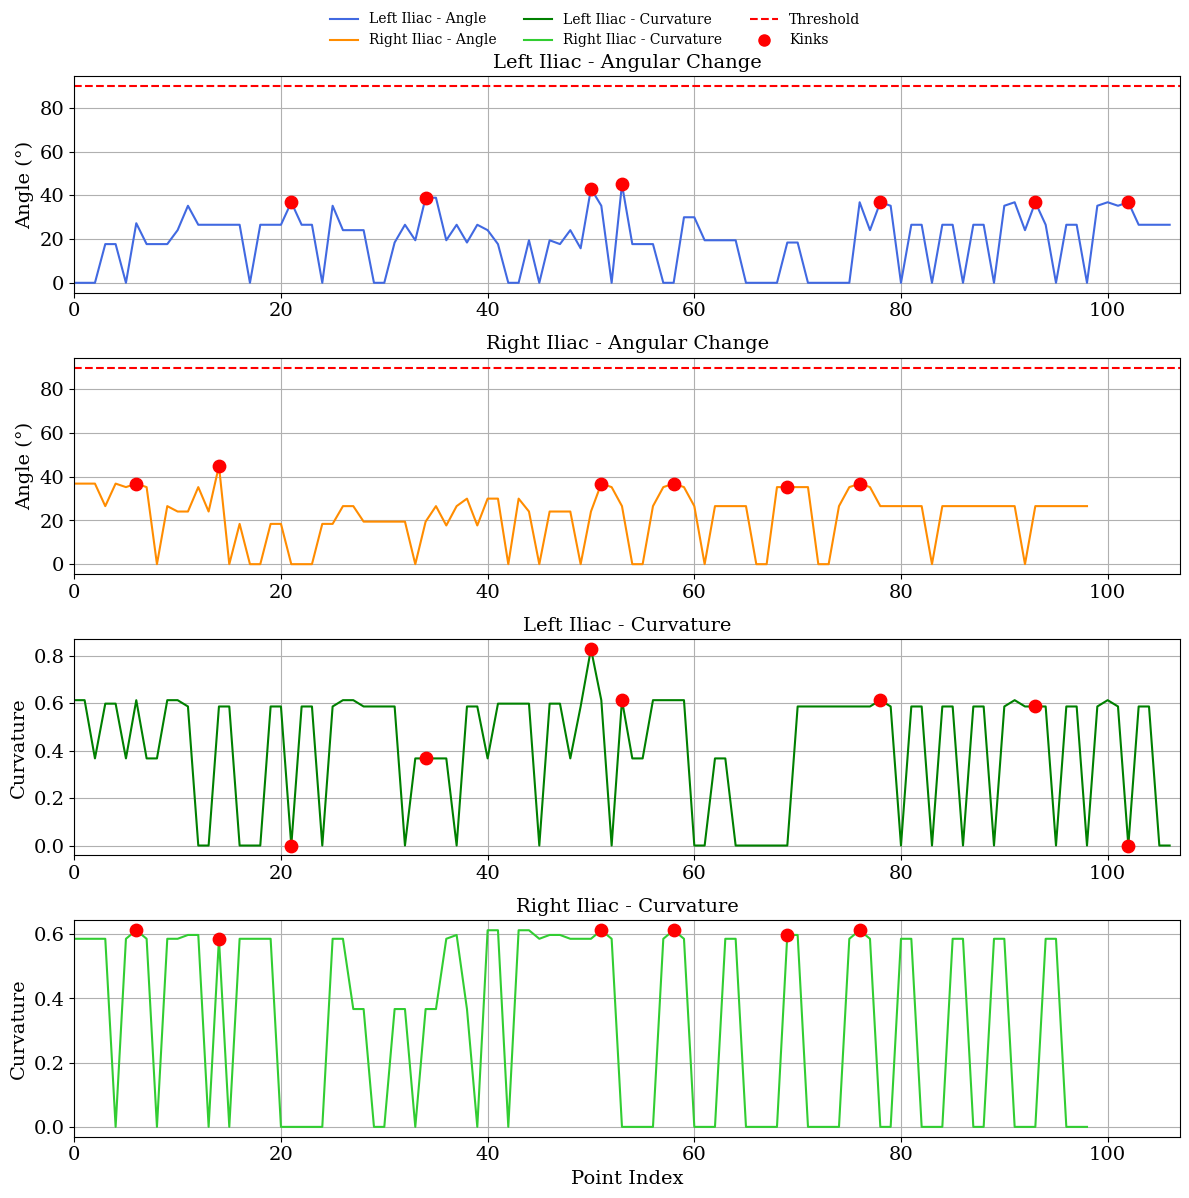

In [179]:
fig = plot_vertical_comparison_with_kinks(analyzer_left, analyzer_right)
plt.show()



# Angle Plots Only 

In [14]:
def plot_comparison_with_kinks(analyzer_left: VesselKinkingAnalyzer,
                                                           analyzer_right: VesselKinkingAnalyzer,
                                                           label_left: str = "Left Iliac",
                                                           label_right: str = "Right Iliac",
                                                           figsize=(10, 6)) -> plt.Figure:
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    # Colors
    angle_color_left = 'royalblue'
    angle_color_right = 'darkorange'
    curv_color_left = 'green'
    curv_color_right = 'limegreen'
    kink_color = 'red'

    # Max lengths for alignment
    max_len_angle = max(len(analyzer_left.angles), len(analyzer_right.angles))
    max_len_curv = max(len(analyzer_left.curvature), len(analyzer_right.curvature))

    # ---------- Angular Change: Left ----------
    axs[0].plot(analyzer_left.angles, label=f'{label_left} - Angle', color=angle_color_left)
    axs[0].axhline(y=analyzer_left.config.angle_threshold, color='red', linestyle='--', label='Threshold')
    if analyzer_left.kink_indices:
        axs[0].scatter(analyzer_left.kink_indices,
                       [analyzer_left.angles[i] for i in analyzer_left.kink_indices],
                       color=kink_color, s=80, zorder=5, label='Kinks')
    axs[0].set_xlim(0, max_len_angle)
    axs[0].set_title(f'{label_left} - Angular Change')
    # axs[0].set_xlabel('Index or Point (From bottom to top)')
    # axs[0].set_ylabel('Angle (°)')
    axs[0].grid(True)

    # ---------- Angular Change: Right ----------
    axs[1].plot(analyzer_right.angles, label=f'{label_right} - Angle', color=angle_color_right)
    axs[1].axhline(y=analyzer_right.config.angle_threshold, color='red', linestyle='--')
    if analyzer_right.kink_indices:
        axs[1].scatter(analyzer_right.kink_indices,
                       [analyzer_right.angles[i] for i in analyzer_right.kink_indices],
                       color=kink_color, s=80, zorder=5)
    axs[1].set_xlim(0, max_len_angle)
    axs[1].set_title(f'{label_right} - Angular Change')
    # axs[1].set_xlabel('Index or Point (From bottom to top)')
    # axs[1].set_ylabel('Angle (°)')
    axs[1].grid(True)

    # ---------- Shared Legend ----------
    handles = [
        plt.Line2D([0], [0], color=angle_color_left, label=f'{label_left}'),
        plt.Line2D([0], [0], color=angle_color_right, label=f'{label_right}'),
        plt.Line2D([0], [0], linestyle='--', color='red', label='Threshold 90°'),
        plt.Line2D([0], [0], marker='o', linestyle='', color='red', label='Kinks', markersize=8)
    ]
    fig.supxlabel('Index or Point (From bottom to top)', fontsize=14)
    fig.supylabel('Angle (°)', fontsize=14)
    fig.legend(handles=handles, loc='upper center', ncol=4, fontsize=14, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for legend
    return fig


In [15]:
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 14,
    "mathtext.fontset": "cm"
})

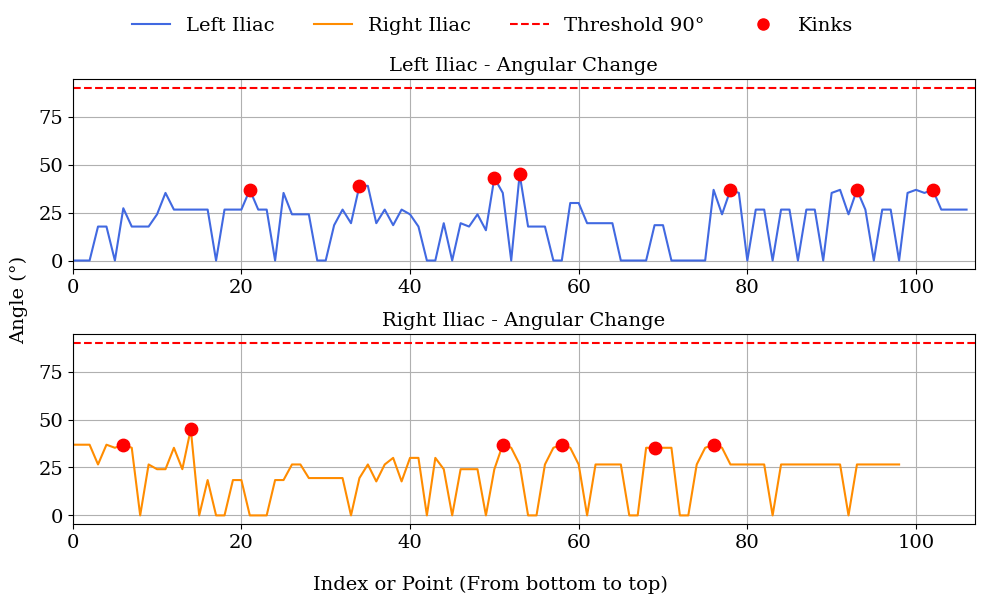

In [17]:
fig = plot_comparison_with_kinks(analyzer_left, analyzer_right)
plt.savefig("Angle_comparison.png", dpi=300, transparent=True)
plt.show()

# Skeleton with mask overlay

In [161]:
import nibabel as nib
import numpy as np
import pandas as pd
import pyvista as pv
from pathlib import Path

In [ ]:
def load_nifti_mask(path):
    nii = nib.load(path)
    data = nii.get_fdata() > 0  # convert to binary
    return data.astype(np.uint8), nii.affine

def load_centerline(path):
    df = pd.read_csv(path)
    return df[['X', 'Y', 'Z']].values  # adjust column names if needed

def render_mask_with_centerlines(mask, affine, centerlines, kink_points=None, opacity=0.15):
    # Create volume grid from mask
    grid = pv.UniformGrid()
    grid.dimensions = np.array(mask.shape)[::-1] + 1  # (X, Y, Z) + 1
    voxel_spacing = np.abs(np.diag(affine)[:3])  # assumes affine is mostly diagonal
    grid.spacing = voxel_spacing[::-1]
    grid.origin = affine[:3, 3][::-1]
    grid.cell_data["values"] = mask.flatten(order="F")

    plotter = pv.Plotter()
    plotter.add_volume(grid, scalars="values", opacity=opacity, cmap="gray", show_scalar_bar=False)

    # Add centerlines
    for cl, color in centerlines:
        plotter.add_lines(cl, color=color, width=3)

    # Add kinks (optional)
    if kink_points:
        for pts in kink_points:
            plotter.add_points(pts, color='red', point_size=10)

    # Legend
    legend_items = [
        ["Left Centerline", "blue"],
        ["Right Centerline", "green"],
        ["Kinks", "red"],
        ["Mask", "gray"]
    ]
    plotter.add_legend(legend_items)
    plotter.show()

In [ ]:

# File paths
mask_path = Path("iliac_mask.nii.gz")
left_csv = Path("left_centerline.csv")
right_csv = Path("right_centerline.csv")

# Load data
mask, affine = load_nifti_mask(mask_path)
left_cl = load_centerline(left_csv)
right_cl = load_centerline(right_csv)
mask, affine = load_nifti_mask(mask_path)
left_cl = load_centerline(left_csv)
right_cl = load_centerline(right_csv)

# Optional: Kink indices (if you have them)
# Example: [10, 25, 30] as kink indices in the left centerline
kinks_left = left_cl[[10, 25, 30]]
kinks_right = right_cl[[12, 28]]

render_mask_with_centerlines(
    mask,
    affine,
    centerlines=[
        (left_cl, 'blue'),
        (right_cl, 'green')
    ],
    kink_points=[
        kinks_left,
        kinks_right
    ],
    opacity=0.15
)

In [162]:
df_right_iliac = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Illiac/Diameters/040_diameters_r_illiac.csv")
df_left_iliac = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Illiac/Diameters/040_diameters_l_illiac.csv")
df_aorta = pd.read_csv("/Users/mahdiislam/Higher_Studies/THESIS/Aorta_seg/Diameter_Cal_Output_Robust/GT_v2/Aorta/Diameters/040_diameters_aorta.csv")

points_left = df_left_iliac[['X', 'Y', 'Z']].values
points_right = df_right_iliac[['X', 'Y', 'Z']].values
points_aorta = df_aorta[['X', 'Y', 'Z']].values

In [163]:
analyzer_left = VesselKinkingAnalyzer(config)
analyzer_left.load_centerline(points_left)
analyzer_left.compute_directional_changes()
analyzer_left.compute_curvature()
analyzer_left.detect_kinks()

analyzer_right = VesselKinkingAnalyzer(config)
analyzer_right.load_centerline(points_right)
analyzer_right.compute_directional_changes()
analyzer_right.compute_curvature()
analyzer_right.detect_kinks()

[np.int64(4), np.int64(26), np.int64(29)]